## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

---

### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

---



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm

# Especifica la ruta de tu archivo CSV
ruta_archivo_csv = 'amz_uk_price_prediction_dataset.csv'
df = pd.read_csv(ruta_archivo_csv)

df.sample(10)


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
169469,181700,B09NYDY3FJ,Gabri Professional Barber Cologne No. 2 - Oran...,5.0,2,7.60,False,0,Fragrances
2353155,2711300,B09HC1NDX8,"Solar Lights for Garden Decoration,Christmas 6...",4.3,46,24.99,False,0,String Lights
861254,937562,B0CJ821HWP,"XINYIN 7"" LCD Screen High Resolution 800x480 R...",0.0,0,89.08,False,0,Monitors
1682485,1895558,B09LQKL83C,"Ballsea Inflatable Projector Screen, 14Ft Port...",4.4,10,100.99,False,0,Camera & Photo Accessories
1039924,1149272,B07TMY7BLX,"STYLPRO Luxury Professional Makeup Brushes, Se...",4.8,19,9.99,False,0,Make-up
1189674,1314451,B0B96JGGXN,"LIQEE Piano Stool,Dressing Table Stool Deluxe ...",0.0,0,484.00,False,0,Piano & Keyboard
456172,490736,B0CJC5QPY7,Hoothy-Herren Mens Jackets Fall Tailcoat Jacke...,0.0,0,28.49,False,0,Sports & Outdoors
699870,755179,B0C28866W4,for Brush Cutter FS400 MS210 ST021 MS230 ST023...,0.0,0,15.24,False,0,Mowers & Outdoor Power Tools
926984,1008458,B0C6KSLRK6,NHNKB Tunic Women's Summer Top Women's Blouses...,0.0,0,7.69,False,0,Sports & Outdoors
1691730,1905247,B0BNQL7G71,"66W Car Charger, TechRise Fast Car Charger Ada...",4.4,273,9.99,False,0,Mobile Phones & Communication


In [2]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result.sample(20)
crosstab_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 3D Printers to eBook Readers & Accessories
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   False   296 non-null    int64
 1   True    296 non-null    int64
dtypes: int64(2)
memory usage: 6.9+ KB


In [3]:
count_best_seller = df[df['isBestSeller'] == 1].groupby('category')['isBestSeller'].count()

count_best_seller

category
3D Printers                         1
3D Printing & Scanning              2
Abrasive & Finishing Products       5
Action Cameras                      1
Adapters                            3
                                 ... 
Wearable Technology                30
Wind Instruments                    7
Window Treatments                   5
Women                             213
Women's Sports & Outdoor Shoes     20
Name: isBestSeller, Length: 260, dtype: int64

In [4]:
_, p_value, _, _ = chi2_contingency(crosstab_result)
p_value

0.0

In [5]:
type(p_value)

numpy.float64

In [6]:
association(crosstab_result, method='cramer')

0.1222829439760564

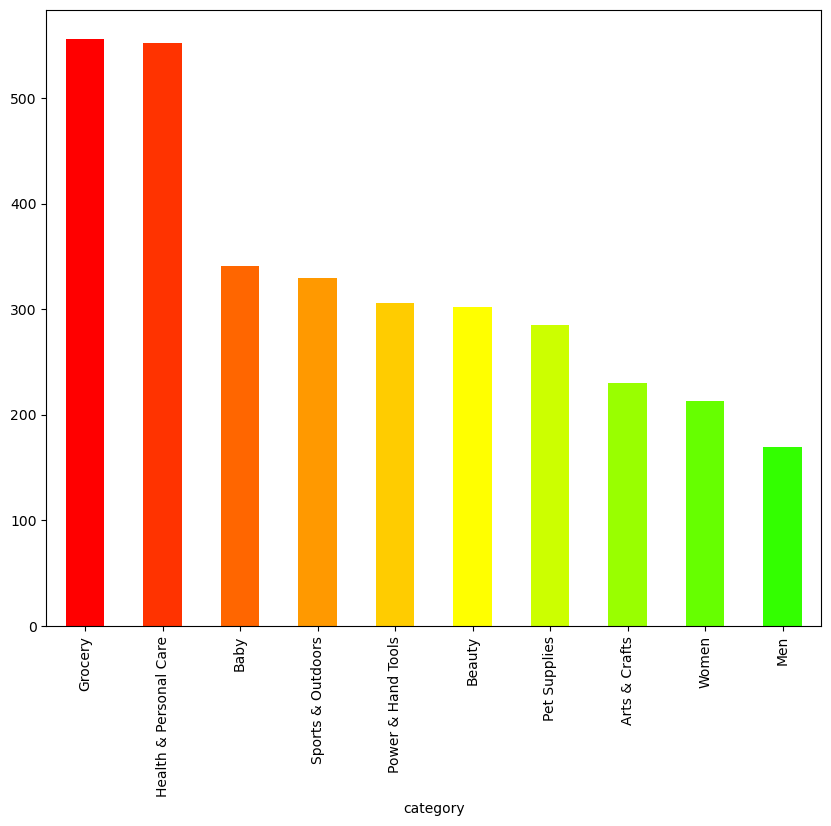

In [9]:
top5_categories = count_best_seller.nlargest(10)
crosstab_top5 = top5_categories[top5_categories.index]

colors = ['#ff0000', '#ff3300', '#ff6600', '#ff9900', '#ffcc00', '#ffff00', '#ccff00', '#99ff00', '#66ff00', '#33ff00']

plt.figure(figsize=(10, 8))
crosstab_top5.plot(kind="bar", stacked=True, color=colors)
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

---



In [10]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

IQR = Q3 - Q1

minimo = Q1 - 1.5 * IQR
maximo = Q3 + 1.5 * IQR

df_no_outliers = df[(df['price'] >= minimo) & (df['price'] <= maximo)]

In [11]:
Q1


9.99

In [12]:
Q3

45.99

In [13]:
IQR

36.0

In [14]:
df_no_outliers

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


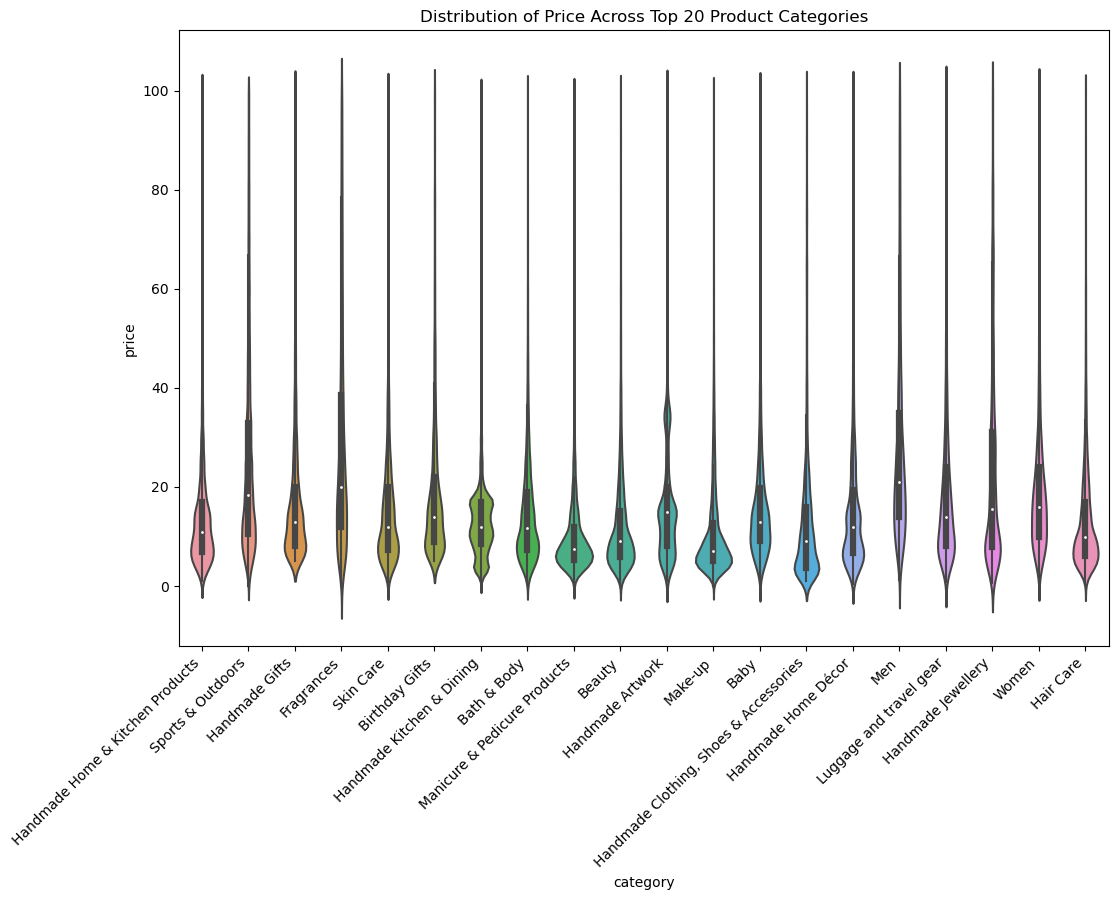

In [15]:
top_categories = df_no_outliers['category'].value_counts().nlargest(20).index
df_top20 = df_no_outliers[df_no_outliers['category'].isin(top_categories)]

plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='price', data=df_top20)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Price Across Top 20 Product Categories')
plt.show()

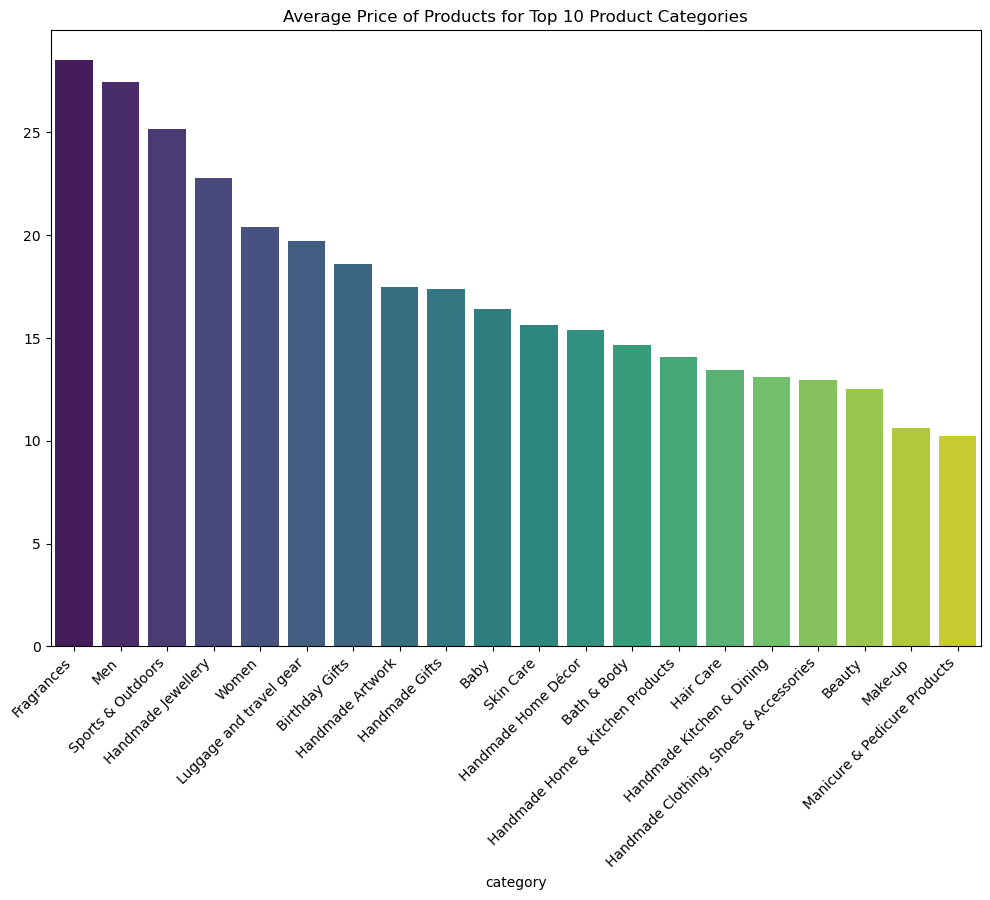

In [17]:
average_prices = df_top20.groupby('category')['price'].mean().sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=average_prices.index, y=average_prices.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Average Price of Products for Top 10 Product Categories')
plt.show()

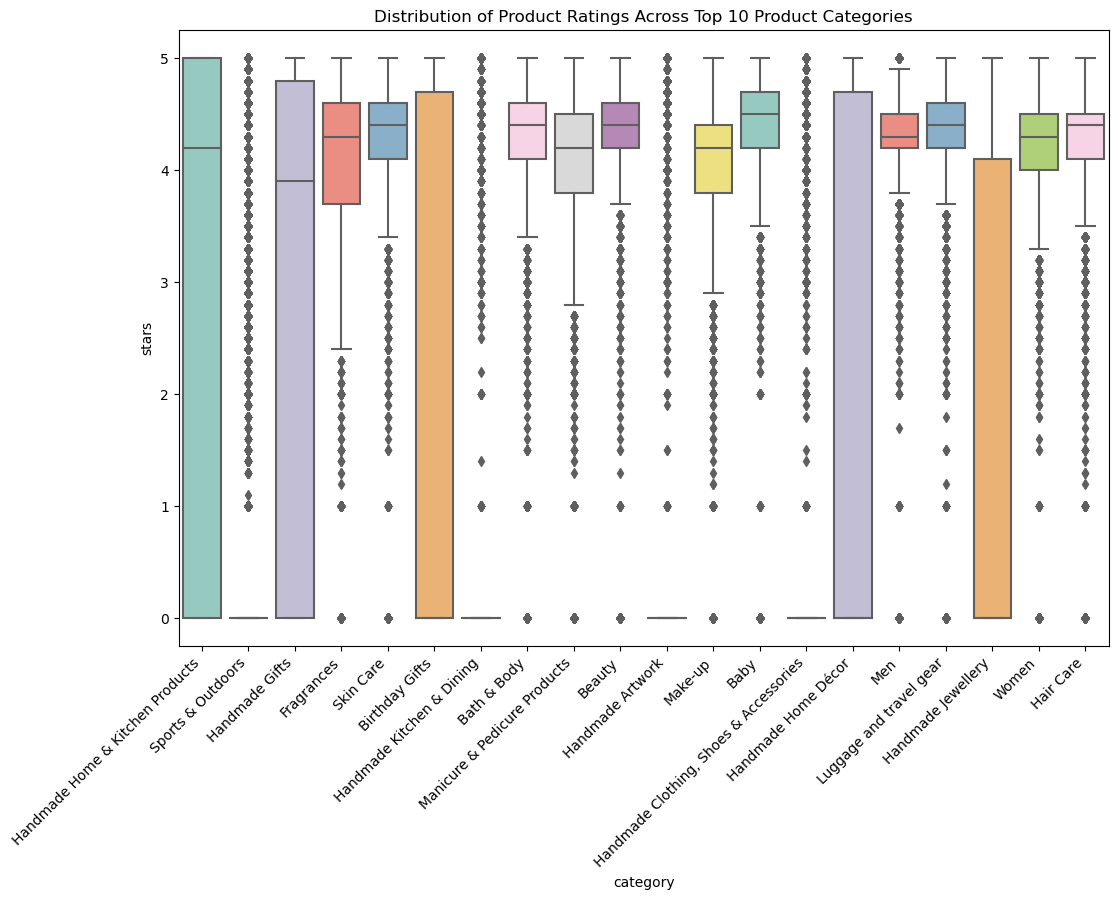

In [19]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='stars', data=df_top20, palette="Set3")
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Product Ratings Across Top 10 Product Categories')
plt.show()

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

---

**Submission**: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings. 

**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?

In [20]:
corr = df_no_outliers['price'].corr(df_no_outliers['stars'])

In [21]:
corr

-0.07767299878181323

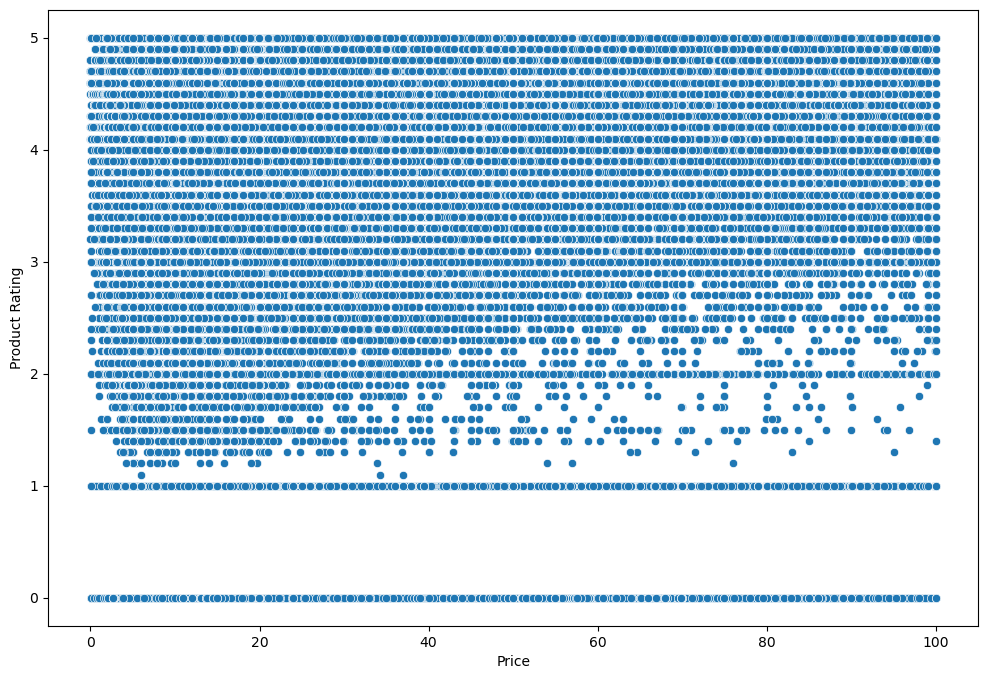

In [22]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_no_outliers, x="price", y="stars")
plt.xlabel('Price')
plt.ylabel('Product Rating')
plt.show()

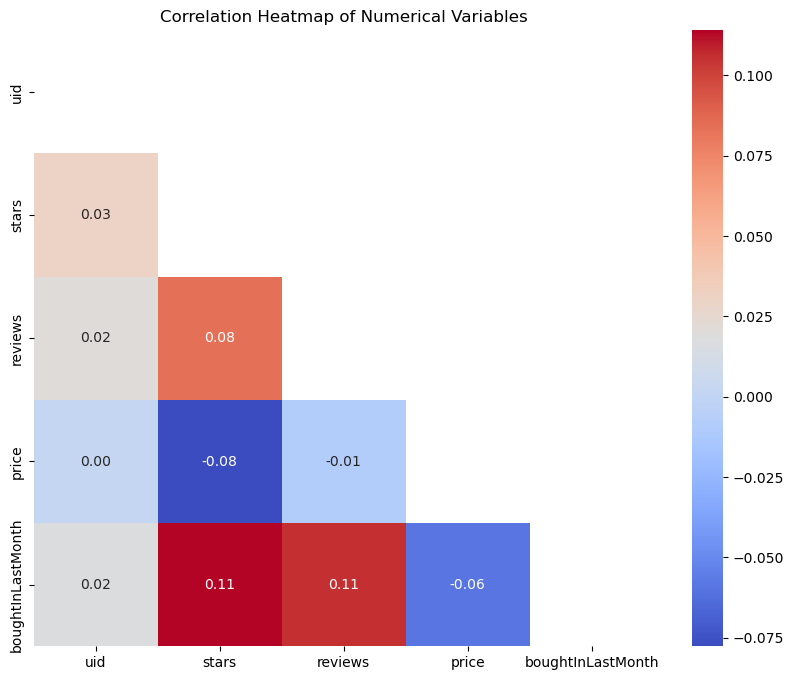

In [30]:
df_numerical = df_no_outliers.select_dtypes(include='number')
correlation_matrix = df_numerical.corr()

mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

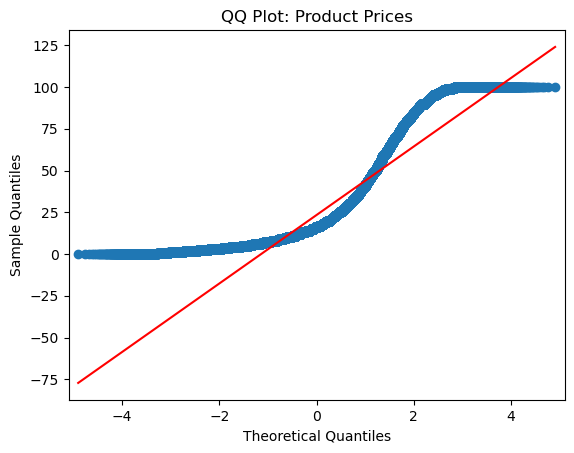

In [24]:
sm.qqplot(df_no_outliers['price'], line='s')  

# Ajusta las etiquetas y el título
plt.title('QQ Plot: Product Prices')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Muestra el gráfico
plt.show()